In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configurar TensorFlow para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], False)
    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])

In [3]:
#Definir rutas de las carétas que contienen las imágenes
directorio = "../../../imagenes/mexh/"
img_width, img_height = 250, 250
input_shape = (img_width, img_height, 1)

#Hiperparámetros
epochs =100
batch_size = 16

In [4]:
# Configurar el generador de datos de imágenes
generador_datos = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Cargar y dividir los datos en conjuntos de entrenamiento y prueba
generador_entrenamiento = generador_datos.flow_from_directory(
    directorio,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

generador_validacion = generador_datos.flow_from_directory(
    directorio,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
tamanio_ventana = (2,2)

# Definir el modelo CNN
clasificador = Sequential()

clasificador.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
clasificador.add(MaxPooling2D(pool_size=tamanio_ventana))
clasificador.add(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
clasificador.add(MaxPooling2D(pool_size=tamanio_ventana))
clasificador.add(Conv2D(8, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
clasificador.add(MaxPooling2D(pool_size=tamanio_ventana))


# Capa de aplanamiento
clasificador.add(Flatten())

# Se agregan las capas densas
clasificador.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)))
clasificador.add(Dropout(rate=0.5))

# Capa de salida
clasificador.add(Dense(units=1, activation='sigmoid'))

In [6]:
# Compilar el modelo
clasificador.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
#Se define un callback para guardar el mejor modelo basado en el val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath = "modelo_generado/mejor_modelo.keras",
    monitor = "val_accuracy",
    save_best_only = True,
    mode = "max",
    verbose = 1
)

# Entrenar el modelo
history = clasificador.fit(
    generador_entrenamiento,
    steps_per_epoch=generador_entrenamiento.samples // batch_size,
    epochs=epochs,
    validation_data=generador_validacion,
    validation_steps=generador_validacion.samples // batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 0.7810 - accuracy: 0.6366
Epoch 1: val_accuracy improved from -inf to 0.69500, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 13s 52ms/step - loss: 0.7798 - accuracy: 0.6369 - val_loss: 0.6691 - val_accuracy: 0.6950
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.6530
Epoch 2: val_accuracy improved from 0.69500 to 0.70500, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 8s 40ms/step - loss: 0.6669 - accuracy: 0.6541 - val_loss: 0.6106 - val_accuracy: 0.7050
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.6628
Epoch 3: val_accuracy improved from 0.70500 to 0.73500, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 8s 38ms/step - loss: 0.6389 - accuracy: 0.6628 - val_loss: 0.6165 - val_accuracy: 0

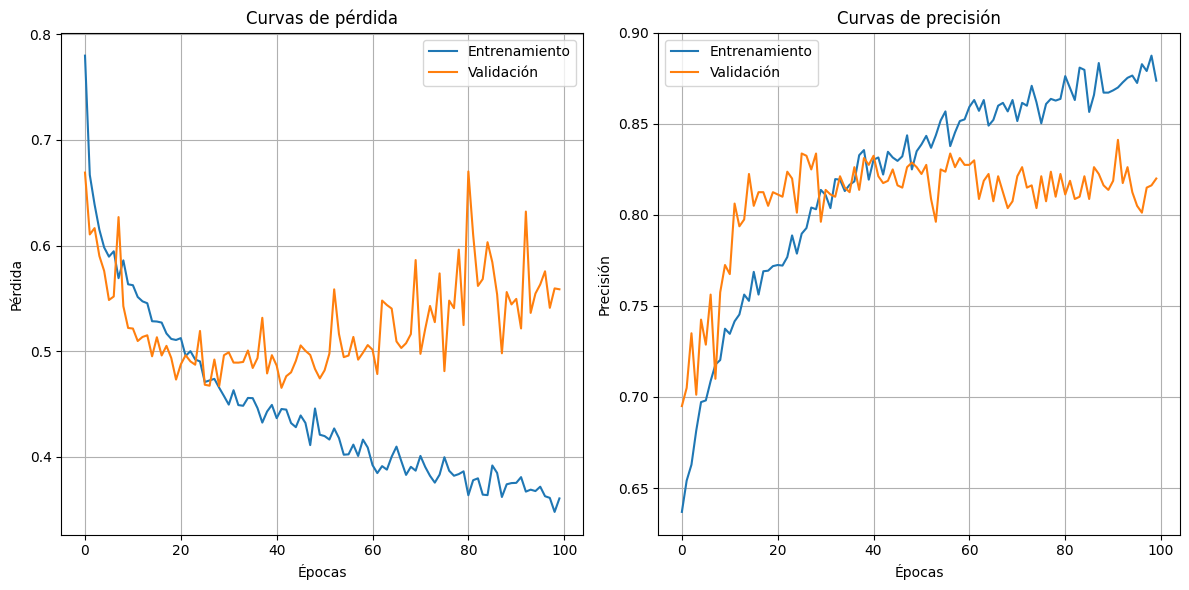

In [8]:
# Graficar las curvas de pérdida y precisión durante el entrenamiento y la validación
plt.figure(figsize=(12, 6))

# Curvas de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Curvas de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()

# Curvas de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Curvas de precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Parte 5:** Evaluación del modelo

Se evalua el mejor modelo guardado

In [9]:
mejor_modelo = load_model("modelo_generado/mejor_modelo.keras")
resul_eva = mejor_modelo.evaluate(generador_validacion, verbose=False)

print("Perdida: {:.2f}".format(resul_eva[0]))
print("Accuracy: {:.2%}".format(resul_eva[1]))

Perdida: 0.52
Accuracy: 84.13%


Cálculo de diferentes métricas


Matriz de Confusión:


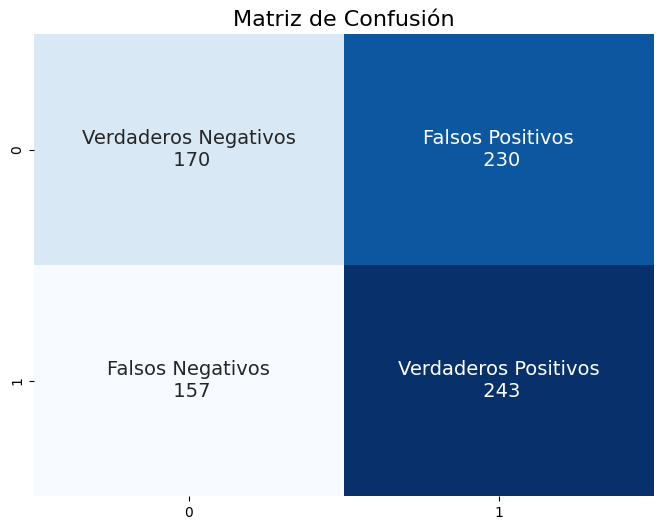

Accuracy:	51.62%
Sensitivity:	60.75%
Specificity:	42.50%
Precision:	51.37%
F1-score:	55.67%


In [10]:
# Obtener las predicciones del modelo
y_pred_prob = mejor_modelo.predict(generador_validacion, verbose=False)

# Convertir las probabilidades en clases binarias usando un umbral (por ejemplo, 0.85)
y_pred = (y_pred_prob > 0.5).astype(int)

# Obtener las etiquetas verdaderas
y_test = generador_validacion.classes

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calcular sensitivity y specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Sensitivity:\t{:.2%}".format(sensitivity))
print("Specificity:\t{:.2%}".format(specificity))
print("Precision:\t{:.2%}".format(precision))
print("F1-score:\t{:.2%}".format(f1))